# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [249]:
import numpy as np
from scipy import optimize
import sympy as sm
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Basic Solow Model


\begin{equation}
Y_t = AK_t^{\alpha}L_t^{1-\alpha} \tag{1}
\end{equation}
\begin{equation}
S_t = sY_t \tag{2}
\end{equation}
\begin{equation}
K_{t+1} - K_t = S_t -\delta K_t \tag{3}
\end{equation}
\begin{equation}
L_{t+1} = (1+n)L_t \tag{4}
\end{equation}
\begin{equation}
y_t = \frac{Y_t}{L_t} = Ak_t^{\alpha} \tag{5}
\end{equation}
\begin{equation}
k_t = \frac{K_t}{L_t} \tag{6}
\end{equation}




In [250]:
Y = sm.symbols("Y_t")          #GDP in the economy
y = sm.symbols("y_t")          #GDP per worker
K = sm.symbols("K_t")          #Capital in the economy
K_next = sm.symbols("K_{t+1}") #Capital in the economy next period
k = sm.symbols("k_t")          #Capital per worker
k_next = sm.symbols("k_{t+1}") #Capital per worker
s = sm.symbols("s")            #Rate of savings
n = sm.symbols("n")            #Population growth
g = sm.symbols("g")            #Growth in technology
A = sm.symbols("A")            #Total factor productivity
L = sm.symbols("L_t")          #Labour
L_next = sm.symbols("L_{t+1}") #Labour next period
alpha = sm.symbols("alpha")    #Return on capital
delta = sm.symbols("delta")    #Depreciation rate on capital
kstar = sm.symbols("k^*")    #Steady state for capital
ystar = sm.symbols("y^*")      #Steady state for GDP per worker



In [251]:
r = sm.symbols("r_t")          #Real rental rate
w = sm.symbols("w_t")          #Real wage

\begin{equation}
r_t = \alpha A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{7}
\end{equation}
\begin{equation}
w_t = (1-\alpha) A \left(\frac{K_t}{L_t}\right)^{\alpha-1} \tag{8}
\end{equation}

In [252]:
##production_function = sm.Eq(A * K**(alpha) * L**(1-alpha), Y)

In [253]:
foc_wrt_K = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), K)),r)
foc_wrt_K

Eq(A*K_t**(alpha - 1)*L_t**(1 - alpha)*alpha, r_t)

In [254]:
foc_wrt_L = sm.Eq(sm.simplify(sm.diff(A * K**(alpha) * L**(1-alpha), L)),w)
foc_wrt_L

Eq(-A*K_t**alpha*L_t**(-alpha)*(alpha - 1), w_t)

# Capital Accumulation

By inserting equation 1 in 2 and then inserting that in equation 3, finally we divide by equation 4 to end up at the transition equation

In [255]:
Transition_equation = sm.simplify(sm.Eq((((1/(1+n))*(A*s*k**(alpha)+(1-delta)*k))), k_next))

In [256]:
Transition_equation


Eq(k_{t+1}, (A*k_t**alpha*s - k_t*(delta - 1))/(n + 1))

To find the steady state of capital, we use that $$\begin{equation}
k_{t+1}=k_t=k^*
\end{equation}$$
 in steady state.


In [257]:
steady_state_capital = sm.solve(((A*s*kstar**(alpha)-(delta-1)*kstar)/(1+n)-kstar), kstar)
steady_state_capital[0]

((delta + n)/(A*s))**(1/(alpha - 1))

In [258]:
sm.Eq(steady_state_capital[0], kstar)

Eq(((delta + n)/(A*s))**(1/(alpha - 1)), k^*)

Using this result and using equation 5, we get the following steady state output

In [259]:
steady_state_output = sm.simplify(A*steady_state_capital[0]**alpha)
sm.Eq(ystar, steady_state_output)

Eq(y^*, A*(((delta + n)/(A*s))**(1/(alpha - 1)))**alpha)

In [260]:
steady_state_capital_func = sm.lambdify((delta,n,A,s,alpha),steady_state_capital[0])

def _steady_state_capital_func(delta,n,A,s,alpha):
    return steady_state_capital_func(delta,n,A,s,alpha)




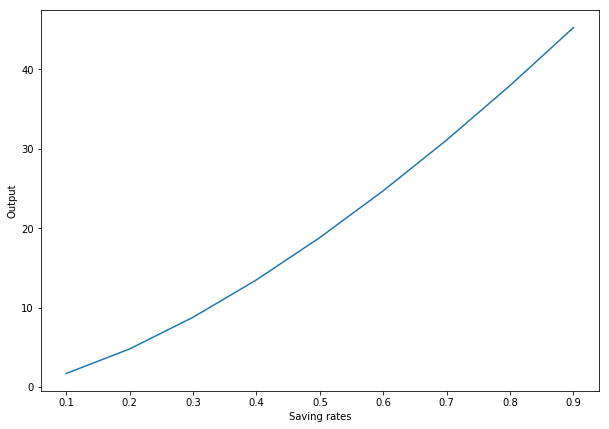

In [261]:
delta= 0.05
n= 0.02
A= 1
#labels = ("0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9",)
savings_vec = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
alpha = 0.33
steady_state_capital_func(delta,n,A,savings_vec,alpha)
plt.figure(figsize=(10,7))
plt.xlabel("Saving rates")
plt.ylabel("Output")
plt.plot(savings_vec,steady_state_capital_func(delta,n,A,savings_vec,alpha));

In [262]:
def solow_graph_1(k,delta,n,A,s,alpha):

        # savings path
    svec = []
        # depreciation path
    deltavec = []

    for t in range(1,k):
        depreciation = (delta+n)*t
        deltavec.append(depreciation)
   

    for t in range(1,k):
        savings = s*A*t**alpha
        svec.append(savings)
    
    #for t in range(1, k):
        #k_extended = A*t**alpha
        #yvec.append(k_extended)
    
#$sAk_t^{\u03B1}$'

    plt.figure(figsize=(15,15))
    plt.plot(deltavec[:k], label = '$(n+\delta)k_t$', color = 'black')
    #plt.plot(kvec[:k], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(svec[:k], color = 'green')
    #for y, label in zip(savings_vec, labels):
        #plt.plot(svec[:k], label=label)
    plt.xlim(0,k)
    plt.ylim(0,deltavec[-1])
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    plt.legend(['$(n+\delta)k_t$', '$sAk_t^{\u03B1}$, s=0.9', '$sAk_t^{\u03B1}$, s=0.8', '$sAk_t^{\u03B1}$, s=0.7', '$sAk_t^{\u03B1}$, s=0.6', '$sAk_t^{\u03B1}$, s=0.5', '$sAk_t^{\u03B1}$, s=0.4', '$sAk_t^{\u03B1}$, s=0.3', '$sAk_t^{\u03B1}$, s=0.2', '$sAk_t^{\u03B1}$, s=0.1'])
    return plt.show()

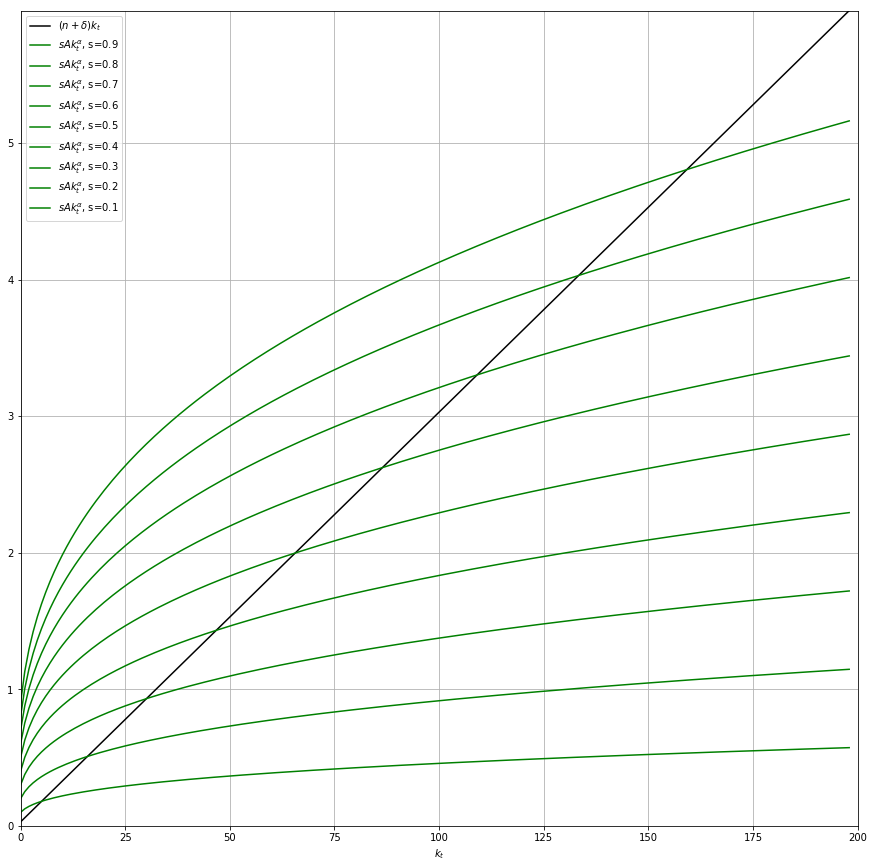

In [263]:
solow_graph_1(200,0.02,0.01,1,savings_vec,0.33)

In [264]:
widgets.interact(solow_graph_1, 
                k_0     = widgets.fixed(0), 
                alpha = widgets.FloatSlider(description = '\u03B1' , min = 0 ,    max = 0.9 , step = 0.01 , value = 0.33),
                delta = widgets.FloatSlider(description = '\u03B4' , min = 0 ,    max = 0.1 , step = 0.01 , value = 0.01),
                s     = widgets.FloatSlider(description = 's' ,        min = 0.01, max = 0.9 , step = 0.01 , value = 0.4),
                n     = widgets.FloatSlider(description ='n',        min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
                A     = widgets.fixed(1),
                k     = widgets.IntSlider(description='k' ,          min = 1,     max = 1001, step = 10,    value = 100))

interactive(children=(IntSlider(value=100, description='k', max=1001, min=1, step=10), FloatSlider(value=0.01,…

<function __main__.solow_graph_1(k, delta, n, A, s, alpha)>

In [265]:
def float_count(start, end):
    float_v = []
    for t in range(start, end):
        float_ext = t/1000+0.01
        float_v.append(float_ext)
    
    return float_v
float_count(1,100)

[0.011,
 0.012,
 0.013000000000000001,
 0.014,
 0.015,
 0.016,
 0.017,
 0.018000000000000002,
 0.019,
 0.02,
 0.020999999999999998,
 0.022,
 0.023,
 0.024,
 0.025,
 0.026000000000000002,
 0.027000000000000003,
 0.027999999999999997,
 0.028999999999999998,
 0.03,
 0.031,
 0.032,
 0.033,
 0.034,
 0.035,
 0.036,
 0.037,
 0.038,
 0.039,
 0.04,
 0.041,
 0.042,
 0.043000000000000003,
 0.044000000000000004,
 0.045000000000000005,
 0.046,
 0.047,
 0.048,
 0.049,
 0.05,
 0.051000000000000004,
 0.052000000000000005,
 0.053,
 0.054,
 0.055,
 0.056,
 0.057,
 0.058,
 0.059000000000000004,
 0.060000000000000005,
 0.061,
 0.062,
 0.063,
 0.064,
 0.065,
 0.066,
 0.067,
 0.068,
 0.06899999999999999,
 0.06999999999999999,
 0.071,
 0.072,
 0.073,
 0.074,
 0.075,
 0.076,
 0.077,
 0.078,
 0.079,
 0.08,
 0.08099999999999999,
 0.08199999999999999,
 0.08299999999999999,
 0.08399999999999999,
 0.08499999999999999,
 0.086,
 0.087,
 0.088,
 0.089,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095,
 0.095999999999999

In [266]:
def solow_graph_3(k_0elta,n,A,s,alpha):
        # capital path
    kvec = [k_0]
        # savings path
    #svec = []
        # depreciation path
    #deltavec = []

    #for t in range(1,k):
        #depreciation = (delta+n)*t
        #deltavec.append(depreciation)
   

    #for t in range(1,k):
        #savings = s*A*t**alpha
        #svec.append(savings)
    
    for (float float_v:< 1.00; t +=0.01) {cout << t << end1;}:
        k_extended = (s * A * t**alpha+t*(1-delta))/ (1+n)
        kvec.append(k_extended)
    
#$sAk_t^{\u03B1}$'

    plt.figure(figsize=(15,15))
    #plt.plot(deltavec[:k], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(kvec[:k], label='$Ak_t^{\u03B1}$', color = 'blue')
    #plt.plot(svec[:k], color = 'green')
    #for y, label in zip(savings_vec, labels):
        #plt.plot(svec[:k], label=label)
    plt.xlim(0,1)
    plt.ylim(0,0.2)
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    #plt.legend(['$(n+\delta)k_t$', 's=0.9', 's=0.8', 's=0.7', 's=0.6', 's=0.5', 's=0.4', 's=0.3', 's=0.2', 's=0.1'])
    return plt.show()

SyntaxError: invalid syntax (<ipython-input-266-f18384b7ba70>, line 18)

In [273]:
solow_graph_3(0,0.02,0.01,1,0.3,0.33,0.33)

TypeError: 'float' object cannot be interpreted as an integer

In [194]:
solow_graph_3(0,0.9,0.9,1,0.3,0.3)

TypeError: solow_graph_3() missing 1 required positional argument: 'alpha'

In [268]:
def solow_equation_1(k, delta, n, A, s, alpha):

    k_extended=(A*k**alpha*s-k*(delta-1)) / (1+n)
    return k_extended 


def solow_graph_4(k_0,delta,n,A,s,alpha,t):

        #cpaital path
    kvec = [k_0]
        # savings path
    #svec = []
        # depreciation path
    #deltavec = []

        
    for t_ in range(1, t):

        k_extended = solow_equation_1(kvec[t_-1], delta,n,A, s, alpha)

        kvec.append(k_extended)
        #svec.append(savings)
        #deltavec.append(depreciation)
    

    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    #plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    #plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'red')
    plt.xlim(0,t)
    plt.ylim(0, )
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    return plt.plot()


In [269]:
solow_graph_4(1,100,0.02,0.05,1,0.3,0.33)

TypeError: 'float' object cannot be interpreted as an integer

In [270]:
def solow_equation(k, delta, n, A, s, alpha):

    savings = s *A* k ** alpha
    depreciation = (delta+n) * k
    k_extended =  k + savings - depreciation 
    return k_extended, savings, depreciation


def solow_graph_2(k_0,delta,n,A,s,alpha,t):

        #cpaital path
    kvec = [k_0]
        # savings path
    svec = []
        # depreciation path
    deltavec = []

        
    for t_ in range(1, t):

        k_extended, savings, depreciation = solow_equation(kvec[t_-1], delta,n,A, s, alpha)

        kvec.append(k_extended)
        svec.append(savings)
        deltavec.append(depreciation)
    

    plt.figure(figsize=(5,5))
    plt.plot(kvec[:t], label='$Ak_t^{\u03B1}$', color = 'blue')
    plt.plot(deltavec[:t], label = '$(n+\delta)k_t$', color = 'black')
    plt.plot(svec[:t], label = '$sAk_t^{\u03B1}$', color = 'red')
    plt.xlim(0,t)
    plt.ylim(0, )
    plt.xlabel('$k_t$')
    plt.grid(True)
    plt.legend()
    return plt.plot()


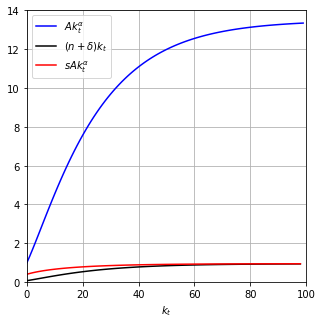

In [271]:
solow_graph_2(1,0.05,0.02,1,0.4,0.33,100);


In [272]:

widgets.interact(
        solow_graph_2,
        k_0=widgets.FloatSlider(
            description="k_0", min=0, max=10, step=0.05, value=2
        ),
        alpha=widgets.FloatSlider(
            description="alpha", min=0.01, max=0.99, step=0.01, value=0.3
        ),
        delta=widgets.FloatSlider(
            description="delta", min=0.01, max=0.50, step=0.01, value=0.05
        ),
        s=widgets.FloatSlider(
            description="s", min=0.01, max=0.99, step=0.01, value=0.33
        ),
        n= widgets.FloatSlider(description ='n', min = -0.1 , max = 0.1 , step = 0.005, value = 0.01),
        A     = widgets.fixed(1),
        t     = widgets.IntSlider(description='t' , min = 1, max = 150, step = 10,  value = 100),
      
    );

interactive(children=(FloatSlider(value=2.0, description='k_0', max=10.0, step=0.05), FloatSlider(value=0.05, …